In [2]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

#ARIMA
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# import pmdarima as pm
# from pmdarima.model_selection import train_test_split
# import itertools
import warnings
warnings.filterwarnings('ignore')


In [3]:
import pyodbc

conn2 = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-V48GDVO\\MSSQLISERVER2022;"
    "Database=DW_ADMISSION;"
    "Trusted_Connection=yes;"
)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_13236\505926781.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


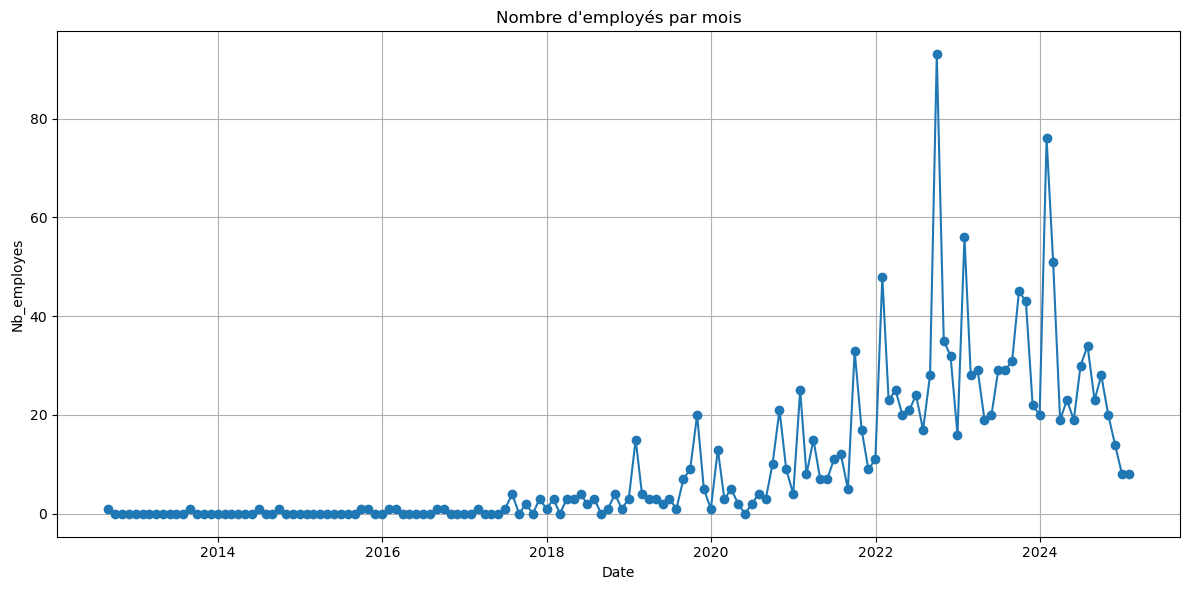

Test de Dickey-Fuller (ADF) sur données mensuelles :
ADF Statistic : -1.4024839494527754
p-value       : 0.5810847042775373
Seuil 1% : -3.4793722137854926
Seuil 5% : -2.8830370378332995
Seuil 10% : -2.578233635380623


In [ ]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Connexion à la base de données
conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-V48GDVO\\MSSQLISERVER2022;"
    "Database=DW_ADMISSION;"
    "Trusted_Connection=yes;"
)

# Requête SQL pour agréger le nombre d'employés par jour
query = """
SELECT 
    D.Date AS Date_Employabilite,
    COUNT(*) AS Nb_employes
FROM dbo.Fact_Employability F
JOIN dbo.Dim_Date D ON F.FK_Date = D.Date_PK
GROUP BY D.Date
ORDER BY D.Date
"""

# Charger les données
df = pd.read_sql(query, conn)
conn.close()

# Conversion en datetime et index
df['Date_Employabilite'] = pd.to_datetime(df['Date_Employabilite'])
df.set_index('Date_Employabilite', inplace=True)

# 🔄 Agrégation mensuelle
df_monthly = df.resample('M').sum()

# 🔍 Visualisation mensuelle
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Nb_employes'], marker='o')
plt.title("Nombre d'employés par mois")
plt.xlabel("Date")
plt.ylabel("Nb_employes")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Test de stationnarité ADF sur les données mensuelles
print("Test de Dickey-Fuller (ADF) sur données mensuelles :")
result = adfuller(df_monthly['Nb_employes'].dropna())
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
for key, value in result[4].items():
    print(f"Seuil {key} : {value}")


In [ ]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Connexion à la base de données
conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-V48GDVO\\MSSQLISERVER2022;"
    "Database=DW_ADMISSION;"
    "Trusted_Connection=yes;"
)

# Requête SQL
query = """
SELECT D.Date AS DateResultat, COUNT(*) AS Nb_employes
FROM dbo.Fact_Employability F
JOIN dbo.Dim_Date D ON F.FK_Date = D.Date_PK
GROUP BY D.Date
ORDER BY D.Date
"""

# Charger les données
df = pd.read_sql(query, conn)
conn.close()

# Préparation
df['DateResultat'] = pd.to_datetime(df['DateResultat'])
df.set_index('DateResultat', inplace=True)
df_daily = df.resample('D').sum()

# Découpage train/test
train = df_daily.iloc[:-30]
test = df_daily.iloc[-30:]

# Modèle ARMA (p=1, d=0, q=1)
model_arma = ARIMA(train, order=(1, 0, 1)).fit()
forecast_arma = model_arma.forecast(steps=30)
rmse_arma = np.sqrt(mean_squared_error(test, forecast_arma))

# Modèle ARIMA (p=1, d=1, q=1)
model_arima = ARIMA(train, order=(1, 1, 1)).fit()
forecast_arima = model_arima.forecast(steps=30)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

# Modèle SARIMA (p,d,q)(P,D,Q,s)
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
forecast_sarima = model_sarima.forecast(steps=30)
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))

# Affichage des résultats
print(f"ARMA RMSE  : {rmse_arma}")
print(f"ARIMA RMSE : {rmse_arima}")
print(f"SARIMA RMSE: {rmse_sarima}")


C:\Users\lenovo\AppData\Local\Temp\ipykernel_13236\2552281860.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
c:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA RMSE  : 1.5485826080533978
ARIMA RMSE : 1.5688153945158416
SARIMA RMSE: 1.6353163452328208


C:\Users\lenovo\AppData\Local\Temp\ipykernel_13236\46480976.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
c:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prévision mensuelle du nombre d'employés (2025-2026) :
         Date  Prévision_Nb_employes
0  2025-02-28              18.335751
1  2025-03-31              19.371629
2  2025-04-30              19.475448
3  2025-05-31              19.485853
4  2025-06-30              19.486896
5  2025-07-31              19.487000
6  2025-08-31              19.487011
7  2025-09-30              19.487012
8  2025-10-31              19.487012
9  2025-11-30              19.487012
10 2025-12-31              19.487012
11 2026-01-31              19.487012
12 2026-02-28              19.487012
13 2026-03-31              19.487012
14 2026-04-30              19.487012
15 2026-05-31              19.487012
16 2026-06-30              19.487012
17 2026-07-31              19.487012
18 2026-08-31              19.487012
19 2026-09-30              19.487012
20 2026-10-31              19.487012
21 2026-11-30              19.487012
22 2026-12-31              19.487012
23 2027-01-31              19.487012


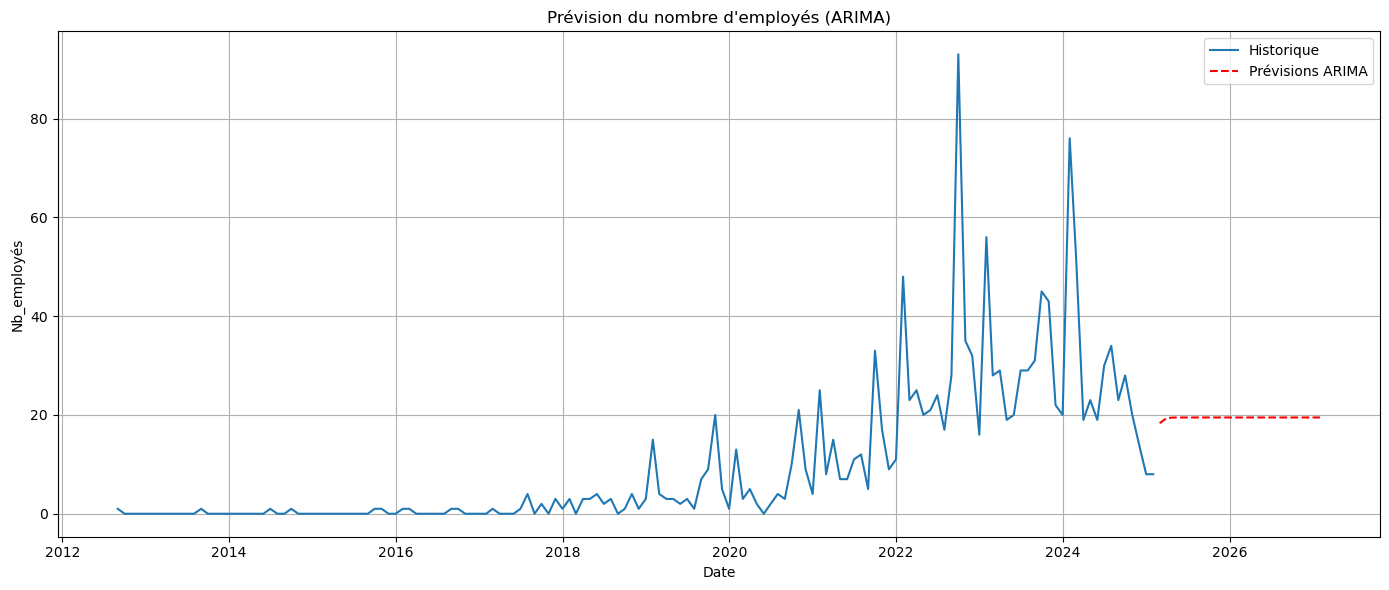

In [ ]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Connexion à la base de données
conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-V48GDVO\\MSSQLISERVER2022;"
    "Database=DW_ADMISSION;"
    "Trusted_Connection=yes;"
)

# Requête SQL pour obtenir le nombre d’employés par mois
query = """
SELECT 
    D.Date,
    COUNT(*) AS Nb_employes
FROM dbo.Fact_Employability FE
JOIN dbo.Dim_Date D ON FE.FK_Date = D.Date_PK
GROUP BY D.Date
ORDER BY D.Date
"""

# Charger les données
df = pd.read_sql(query, conn)
conn.close()

# Prétraitement
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Agrégation mensuelle
df_monthly = df.resample('M').sum()

# Entraînement du modèle ARIMA
model = ARIMA(df_monthly['Nb_employes'], order=(1, 1, 1))
model_fit = model.fit()

# Prévision pour 24 mois (2 ans)
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)

# Index pour les prévisions
forecast_index = pd.date_range(start=df_monthly.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# Affichage de la prévision sous forme de tableau
forecast_df = forecast_series.reset_index()
forecast_df.columns = ['Date', 'Prévision_Nb_employes']
print("Prévision mensuelle du nombre d'employés (2025-2026) :")
print(forecast_df)

# Visualisation
plt.figure(figsize=(14, 6))
plt.plot(df_monthly.index, df_monthly['Nb_employes'], label='Historique')
plt.plot(forecast_series.index, forecast_series, label='Prévisions ARIMA', linestyle='--', color='red')
plt.title("Prévision du nombre d'employés (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Nb_employés")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


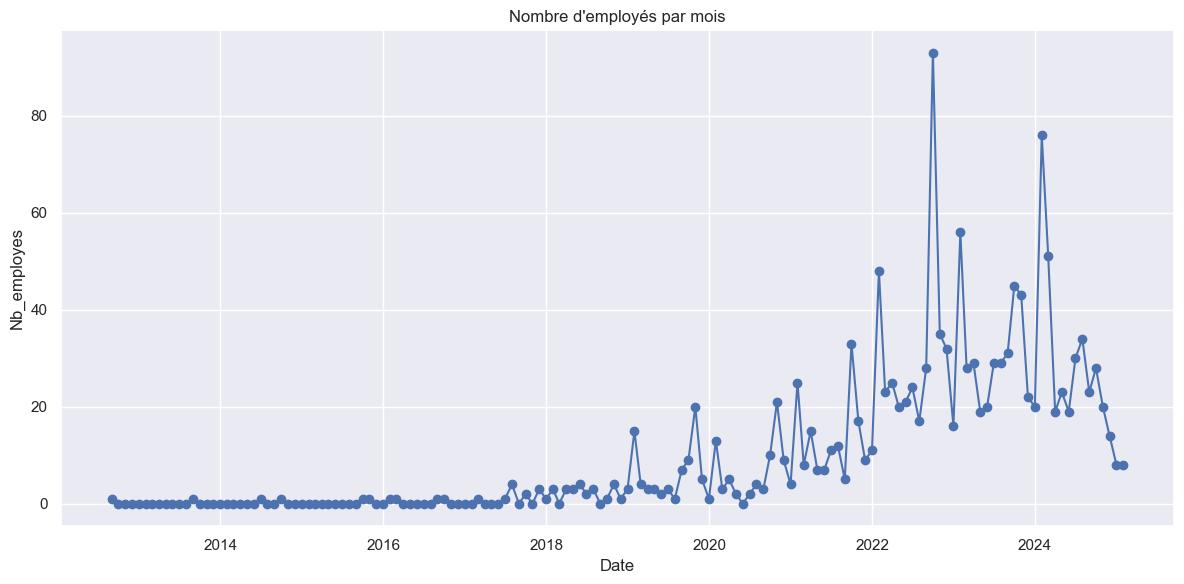

Test de Dickey-Fuller (ADF) sur données mensuelles :
ADF Statistic : -1.4024839494527754
p-value       : 0.5810847042775373
Seuil 1% : -3.4793722137854926
Seuil 5% : -2.8830370378332995
Seuil 10% : -2.578233635380623
Prévision mensuelle du nombre d'employés (2025-2026) :
         Date  Prévision_Nb_employes
0  2025-02-28              18.335751
1  2025-03-31              19.371629
2  2025-04-30              19.475448
3  2025-05-31              19.485853
4  2025-06-30              19.486896
5  2025-07-31              19.487000
6  2025-08-31              19.487011
7  2025-09-30              19.487012
8  2025-10-31              19.487012
9  2025-11-30              19.487012
10 2025-12-31              19.487012
11 2026-01-31              19.487012
12 2026-02-28              19.487012
13 2026-03-31              19.487012
14 2026-04-30              19.487012
15 2026-05-31              19.487012
16 2026-06-30              19.487012
17 2026-07-31              19.487012
18 2026-08-31            

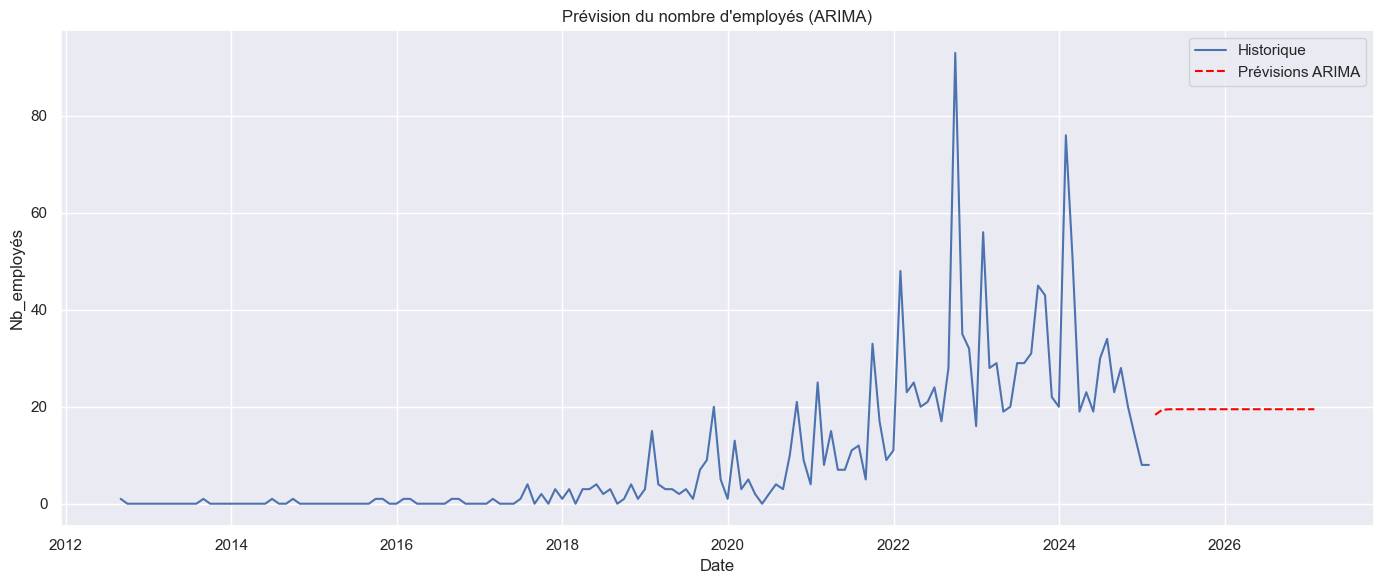

In [ ]:
import pyodbc

conn2 = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-V48GDVO\\MSSQLISERVER2022;"
    "Database=DW_ADMISSION;"
    "Trusted_Connection=yes;"
)
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Connexion à la base de données
conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-V48GDVO\\MSSQLISERVER2022;"
    "Database=DW_ADMISSION;"
    "Trusted_Connection=yes;"
)

# Requête SQL pour agréger le nombre d'employés par jour
query = """
SELECT 
    D.Date AS Date_Employabilite,
    COUNT(*) AS Nb_employes
FROM dbo.Fact_Employability F
JOIN dbo.Dim_Date D ON F.FK_Date = D.Date_PK
GROUP BY D.Date
ORDER BY D.Date
"""

# Charger les données
df = pd.read_sql(query, conn)
conn.close()

# Conversion en datetime et index
df['Date_Employabilite'] = pd.to_datetime(df['Date_Employabilite'])
df.set_index('Date_Employabilite', inplace=True)

# 🔄 Agrégation mensuelle
df_monthly = df.resample('M').sum()

# 🔍 Visualisation mensuelle
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Nb_employes'], marker='o')
plt.title("Nombre d'employés par mois")
plt.xlabel("Date")
plt.ylabel("Nb_employes")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Test de stationnarité ADF sur les données mensuelles
print("Test de Dickey-Fuller (ADF) sur données mensuelles :")
result = adfuller(df_monthly['Nb_employes'].dropna())
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
for key, value in result[4].items():
    print(f"Seuil {key} : {value}")
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Connexion à la base de données
conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-V48GDVO\\MSSQLISERVER2022;"
    "Database=DW_ADMISSION;"
    "Trusted_Connection=yes;"
)

# Requête SQL pour obtenir le nombre d’employés par mois
query = """
SELECT 
    D.Date,
    COUNT(*) AS Nb_employes
FROM dbo.Fact_Employability FE
JOIN dbo.Dim_Date D ON FE.FK_Date = D.Date_PK
GROUP BY D.Date
ORDER BY D.Date
"""

# Charger les données
df = pd.read_sql(query, conn)
conn.close()

# Prétraitement
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Agrégation mensuelle
df_monthly = df.resample('M').sum()

# Entraînement du modèle ARIMA
model = ARIMA(df_monthly['Nb_employes'], order=(1, 1, 1))
model_fit = model.fit()

# Prévision pour 24 mois (2 ans)
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)

# Index pour les prévisions
forecast_index = pd.date_range(start=df_monthly.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# Affichage de la prévision sous forme de tableau
forecast_df = forecast_series.reset_index()
forecast_df.columns = ['Date', 'Prévision_Nb_employes']
print("Prévision mensuelle du nombre d'employés (2025-2026) :")
print(forecast_df)

# Visualisation
plt.figure(figsize=(14, 6))
plt.plot(df_monthly.index, df_monthly['Nb_employes'], label='Historique')
plt.plot(forecast_series.index, forecast_series, label='Prévisions ARIMA', linestyle='--', color='red')
plt.title("Prévision du nombre d'employés (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Nb_employés")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
